# 1. Setup e Imports

In [237]:
# - Local (VS Code): instalar deps con `pip install -r requirements.txt` y correr directo.
# - Colab: esta celda instala solo lo necesario, sin desinstalar nada.

import sys
IN_COLAB = "google.colab" in sys.modules

if IN_COLAB:
    %pip -q install --upgrade --force-reinstall "numpy==1.26.4"
    %pip -q install "pandas>=1.5,<2.3" "matplotlib>=3.7,<3.9" "seaborn>=0.12" "scipy>=1.10,<1.14" "fitter==1.7.1"

# Imports
import os
from pathlib import Path
import json
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from fitter import Fitter
from dataclasses import dataclass
from typing import Optional

# Estilo / reproducibilidad / display
sns.set(style="whitegrid")
np.random.seed(42)
random.seed(42)
pd.set_option("display.width", 120)
pd.set_option("display.max_columns", 50)

# (Opcional) mostrar versiones en Colab
if IN_COLAB:
    import importlib
    for m in ("numpy","pandas","matplotlib","seaborn","scipy","fitter"):
        mod = importlib.import_module(m)
        print(f"{m:>10}: {getattr(mod,'__version__','?')}")

# Placeholders globales para los samplers/ajustes (se completan en ajustar_fdps_desde_df)
gen_TS_dataset = None
gen_LLIN_dataset = None
best_ts_dataset = {}
best_llin_dataset = {}

# 2. Ingesta Dataset externo

In [238]:
# Carpeta de inputs (Colab vs local)
DATA_DIR = Path("/content/inputs") if IN_COLAB else (Path.cwd() / "inputs")
DATA_DIR.mkdir(parents=True, exist_ok=True)

SCENARIO_CSV = DATA_DIR / "blockchain_real_state_data_2021_2022_middle.csv"  # <- cambiar si es otro nombre de archivo

if not SCENARIO_CSV.exists():
    raise FileNotFoundError(
        f"No encuentro el archivo de escenarios: {SCENARIO_CSV}\n"
        f"Colocalo en {DATA_DIR} o cambiá el nombre arriba."
    )

df_scenarios = pd.read_csv(SCENARIO_CSV)
print("✅ Escenarios cargados:", df_scenarios.shape)
print("▶ Ruta:", SCENARIO_CSV)
print("▶ Columnas:", list(df_scenarios.columns))

# Unidad de tiempo de toda la sim
TIME_UNIT = "horas"

✅ Escenarios cargados: (5000, 7)
▶ Ruta: c:\Users\julia\Proyectos\simu-blockchain\inputs\blockchain_real_state_data_2021_2022_middle.csv
▶ Columnas: ['requested_tokenization_delay_min', 'requested_mint_time', 'potential_buyer_arrival_delay_time', 'potential_buyer_buy_time', 'mint_delay_min', 'burn_token_time', 'price_update_time']


# 3. Simulación por escenario

In [239]:
@dataclass
class SimResult:
    df_eventos: pd.DataFrame
    metrics: dict
    saldos_compradores: list

def simular_escenario(row: pd.Series, out_dir: Optional[Path] = None, save_files: bool = False) -> SimResult:
    if save_files and out_dir is not None:
        out_dir.mkdir(parents=True, exist_ok=True)

    # --------- Parámetros desde el dataset (fallbacks si faltara algo) ----------
    N_EVENTOS   = int(row.get("n_eventos", 1000))
    GAS         = float(row.get("gas_fee_usd", 50.0))
    PARTES_MAX  = int(row.get("partes_de_prop", 1000))
    MEAN_TS     = max(1e-6, float(row.get("mint_delay_min", 20.0)) / 60.0)      # min → h
    MEAN_LLIN   = max(1e-6, float(row.get("potential_buyer_arrival_delay_time", 30.0)))  # ya en h
    MEAN_SEC    = max(1e-6, float(row.get("time_to_price_update_days", 3.0)) * 24.0)     # días → h
    P_KYC       = float(row.get("kyc_pass", 0.5))
    P_BURN      = float(row.get("burn_prob", 0.05))
    P_UPDATE    = float(row.get("price_update_prob", 0.10))
    TOKEN_PRICE = float(row.get("token_price_usd", 1000.0))
    BUYER_BUDG  = float(row.get("buyer_budget_usd", 3000.0))
    PRICE_SD    = max(1.0, 0.10 * TOKEN_PRICE)
    BUDG_SD     = max(1.0, 0.15 * BUYER_BUDG)

    if "seed" in row and not pd.isna(row["seed"]):
        seed = int(row["seed"])
        np.random.seed(seed); random.seed(seed)

    partes_de_prop = PARTES_MAX
    tokens_vend = []
    saldo_vend = 5000.0
    eventos = []
    tiempo = 0.0

    CTS = 0; CTF = 0; tokens_emitidos = 0; tokens_burneados = 0; saldos_compradores = []

    # Samplers (horas). Si hay fits desde dataset, usarlos; si no, exponencial
    _gen_ts_candidate   = globals().get('gen_TS_dataset', None)
    _gen_llin_candidate = globals().get('gen_LLIN_dataset', None)
    gen_TS   = _gen_ts_candidate   if callable(_gen_ts_candidate)   else (lambda: np.random.exponential(scale=MEAN_TS))
    gen_LLIN = _gen_llin_candidate if callable(_gen_llin_candidate) else (lambda: np.random.exponential(scale=MEAN_LLIN))
    
    gen_SEC  = lambda: np.random.exponential(scale=MEAN_SEC)

    def _wrap_pos(fn):
        def _inner():
            x = float(fn())
            return 1e-9 if (not np.isfinite(x) or x <= 0.0) else x
        return _inner
    gen_TS = _wrap_pos(gen_TS); gen_LLIN = _wrap_pos(gen_LLIN); gen_SEC = _wrap_pos(gen_SEC)

    def gen_token_price():  return max(10.0, float(np.random.normal(TOKEN_PRICE, PRICE_SD)))
    def gen_buyer_budget(): return max(0.0, float(np.random.normal(BUYER_BUDG, BUDG_SD)))

    # Simulación principal
    for _ in range(N_EVENTOS):
        r = random.random()
        if r < 0.35:
            tiempo += gen_TS()
            if (tokens_emitidos < partes_de_prop) and (saldo_vend >= GAS):
                CTS += 1; saldo_vend -= GAS
                token_id = f"T{tokens_emitidos}"
                tokens_vend.append({"id": token_id, "precio": gen_token_price()})
                tokens_emitidos += 1
                eventos.append([tiempo, "mint", token_id, saldo_vend, None])
        elif r < 0.7:
            tiempo += gen_LLIN()
            if random.random() < P_KYC:
                saldo_comprador = gen_buyer_budget()
                if tokens_vend:
                    token = random.choice(tokens_vend); precio = token["precio"]
                    if saldo_comprador >= precio:
                        saldo_comprador -= precio; saldo_vend += precio
                        tokens_vend.remove(token); saldos_compradores.append(saldo_comprador)
                        eventos.append([tiempo, "compra_exitosa", token["id"], saldo_vend, saldo_comprador])
                    else:
                        CTF += 1; eventos.append([tiempo, "compra_fallida_fondos", token["id"], saldo_vend, saldo_comprador])
                else:
                    CTF += 1; eventos.append([tiempo, "compra_fallida_sin_tokens", None, saldo_vend, saldo_comprador])
        else:
            tiempo += gen_SEC()
            if tokens_vend:
                token = random.choice(tokens_vend); rr = random.random()
                if rr < P_BURN:
                    tokens_vend.remove(token); tokens_burneados += 1
                    eventos.append([tiempo, "burn_token", token["id"], saldo_vend, None])
                elif rr < (P_BURN + P_UPDATE):
                    nuevo_precio = gen_token_price(); token["precio"] = nuevo_precio
                    eventos.append([tiempo, "actualizacion_precio", token["id"], saldo_vend, nuevo_precio])

    df_eventos = pd.DataFrame(eventos, columns=["tiempo","evento","token","saldo_vendedor","extra"])\
                   .sort_values("tiempo", ignore_index=True)
    df_eventos["tiempo"] = pd.to_numeric(df_eventos["tiempo"], errors="coerce")

    assert saldo_vend >= 0
    current_unsold = len(tokens_vend)
    assert tokens_emitidos >= tokens_burneados + current_unsold

    PTB_final_pct = (tokens_burneados / tokens_emitidos * 100.0) if tokens_emitidos > 0 else 0.0
    PSC_final = float(np.mean(saldos_compradores)) if len(saldos_compradores) > 0 else 0.0

    metrics = {
        "CTS": int(CTS), "PTB_%": float(PTB_final_pct), "PSC": float(PSC_final), "CTF": int(CTF),
        "emitidos": int(tokens_emitidos), "burneados": int(tokens_burneados),
        "tiempo_min": float(df_eventos["tiempo"].min()) if len(df_eventos) else 0.0,
        "tiempo_max": float(df_eventos["tiempo"].max()) if len(df_eventos) else 0.0,
        "unidad_tiempo": TIME_UNIT,
    }

    # Guardar resultados
    if save_files and out_dir is not None:
        df_eventos.to_csv(out_dir / "eventos.csv", index=False)
        pd.DataFrame([metrics]).to_csv(out_dir / "metricas.csv", index=False)

    if globals().get("WRITE_FILES_PER_SCENARIO", False):
        df_eventos.to_csv(out_dir / "eventos.csv", index=False)
        pd.DataFrame([metrics]).to_csv(out_dir / "metricas.csv", index=False)

    return SimResult(df_eventos=df_eventos, metrics=metrics, saldos_compradores=saldos_compradores)

# 4. Helper

In [240]:
from fitter import Fitter
from scipy import stats

def ajustar_fdps_desde_df(df, time_unit="horas", topN_plots: int | None = None,
                          out_dir="outputs"):

    os.makedirs(out_dir, exist_ok=True)

    # Series crudas (del dataset), convertidas a HORAS y > 0
    ts_hours   = pd.to_numeric(df["mint_delay_min"], errors="coerce").dropna() / 60.0
    llin_hours = pd.to_numeric(df["potential_buyer_arrival_delay_time"], errors="coerce").dropna()
    ts_hours   = ts_hours[ts_hours > 0]
    llin_hours = llin_hours[llin_hours > 0]

    # Ajuste completo (todas las distribuciones disponibles en fitter)
    f_ts   = None
    f_llin = None
    best_ts_dataset   = {}
    best_llin_dataset = {}

    if len(ts_hours) >= 3:
        f_ts = Fitter(ts_hours)          # TODAS las dists
        f_ts.fit()
        best_ts_dataset = f_ts.get_best(method="sumsquare_error")  # {'dist': {params}}

    if len(llin_hours) >= 3:
        f_llin = Fitter(llin_hours)
        f_llin.fit()
        best_llin_dataset = f_llin.get_best(method="sumsquare_error")

    # Samplers a partir del best (si existiera)
    def _make_sampler(best):
        if not best:
            return None
        name, params = list(best.items())[0]
        # Usamos 'freezing' de scipy.stats con kwargs (shape(s), loc, scale)
        try:
            rv = getattr(stats, name)(**params)
            return lambda: float(rv.rvs(size=1)[0])
        except Exception:
            # Fallback: rvs con kwargs directos
            return lambda: float(getattr(stats, name).rvs(size=1, **params)[0])

    gen_TS_dataset   = _make_sampler(best_ts_dataset)
    gen_LLIN_dataset = _make_sampler(best_llin_dataset)

    # Guardado de resumen del ajuste desde dataset (idempotente)
    rows_ds = []
    def _row_ds(nombre, best, serie):
        if not best:
            return {"variable": nombre, "mejor_dist": "sin_ajuste", "params_json": "{}", "n": int(len(serie)), "unidad_tiempo": time_unit}
        dist, params = list(best.items())[0]
        return {"variable": nombre, "mejor_dist": dist, "params_json": json.dumps(params), "n": int(len(serie)), "unidad_tiempo": time_unit}

    rows_ds.append(_row_ds("TS",   best_ts_dataset,   ts_hours))
    rows_ds.append(_row_ds("LLIN", best_llin_dataset, llin_hours))
    pd.DataFrame(rows_ds).to_csv(os.path.join(out_dir, "ajustes_fdp_dataset.csv"), index=False)
    with open(os.path.join(out_dir, "ajustes_fdp_dataset.json"), "w", encoding="utf-8") as f:
        json.dump(rows_ds, f, ensure_ascii=False, indent=2)

    # ---------- Gráficas Top-N superpuestas (opcional) ----------
    if isinstance(topN_plots, int) and topN_plots > 0:
        def _get_topN_names(f: Fitter, N: int):
            # Intentar obtener ranking desde atributos internos / summary
            try:
                # 1) Si existe dict de SSE
                errs = getattr(f, "sumsquare_error", None) or getattr(f, "sum_square_error", None)
                if errs:
                    return [k for k, _ in sorted(errs.items(), key=lambda kv: kv[1])[:N]]
            except Exception:
                pass
            try:
                # 2) Probar con summary que devuelva DF
                df_sum = f.summary(N)
                if df_sum is not None and hasattr(df_sum, "index"):
                    return list(df_sum.index[:N])
            except Exception:
                pass
            try:
                # 3) Último recurso: primeros N con parámetros ajustados
                names = list(getattr(f, "fitted_param", {}).keys())
                return names[:N]
            except Exception:
                return []

        def _plot_topN_overlay(serie, f: Fitter, var_name: str, topN: int, path_png: str):
            s = np.asarray(serie, dtype=float)
            s = s[np.isfinite(s) & (s > 0)]
            if len(s) < 3 or f is None:
                print(f"⚠️ {var_name}: sin datos suficientes para graficar Top-{topN}.")
                return
            names = _get_topN_names(f, topN)
            if not names:
                print(f"⚠️ {var_name}: no se obtuvo ranking de distribuciones.")
                return

            x = np.linspace(s.min(), s.max(), 400)
            plt.figure(figsize=(9, 5))
            # Histograma normalizado
            plt.hist(s, bins=50, density=True, alpha=0.25, label="Datos")
            # Superposición de PDFs
            for name in names:
                params = None
                # Fitter suele guardar en 'fitted_param'
                fp = getattr(f, "fitted_param", None) or {}
                params = fp.get(name)
                if params is None:
                    continue
                try:
                    rv = getattr(stats, name)(**params)
                    y = rv.pdf(x)
                    plt.plot(x, y, label=name)
                except Exception:
                    # Si algo falla con esa dist, la saltamos
                    continue

            plt.title(f"{var_name} — Top {len(names)} FDPs (pdf)")
            plt.xlabel(f"Δ tiempo ({time_unit})")
            plt.ylabel("Densidad")
            plt.legend()
            plt.tight_layout()
            plt.savefig(path_png, dpi=150)
            plt.show()
            print(f"🖼️ Guardado: {path_png}")

        # Hacer las dos figuras
        _plot_topN_overlay(ts_hours,   f_ts,   "TS",   topN_plots, os.path.join(out_dir, f"fdp_ts_top{topN_plots}_overlay.png"))
        _plot_topN_overlay(llin_hours, f_llin, "LLIN", topN_plots, os.path.join(out_dir, f"fdp_llin_top{topN_plots}_overlay.png"))

    return best_ts_dataset, best_llin_dataset, gen_TS_dataset, gen_LLIN_dataset, f_ts, f_llin

# 4.1 Flags + Helpers - All scenarios

In [241]:
SAVE_EVENTS_ALL    = False   # ← para 54k escenarios: dejarlo en False
EVENTS_SAMPLE_PCT  = 0.00    # p.ej. 0.01 = 1% de eventos por escenario
EVENTS_GZIP        = True    # comprimir eventos si se guardan
EVENTS_SHARD_SIZE  = 500     # escenarios por archivo; 0 o None = un solo archivo
EVENTS_BASENAME    = "eventos_all"  # prefijo de shards

SAVE_METRICAS_ALL  = True    # métricas son livianas → guardarlas siempre

from pathlib import Path

def _events_path_for_shard(base_out: Path, shard_idx: int, gzip: bool) -> Path:
    suf = f"_s{shard_idx:03d}.csv" + (".gz" if gzip else "")
    return base_out / f"{EVENTS_BASENAME}{suf}"

def _append_events(df: pd.DataFrame, scenario_name: str,
                   base_out: Path, shard_idx: int, gzip: bool):
    """Append de eventos (opcionalmente sampleados) en CSV(.gz) por shard."""
    if df is None or df.empty:
        return
    path = _events_path_for_shard(base_out, shard_idx, gzip)
    header = not path.exists()
    df.assign(scenario=scenario_name).to_csv(
        path, mode="a", header=header, index=False,
        compression=("gzip" if gzip else None)
    )
    return path

def _append_metricas(row_dict: dict, base_out: Path):
    """Append de métricas por escenario a un único CSV."""
    path = base_out / "metricas_all.csv"
    header = not path.exists()
    pd.DataFrame([row_dict]).to_csv(path, mode="a", header=header, index=False)
    return path

# 5. Driver

In [242]:
# 4. Driver (streaming, sin subcarpetas)
BASE_OUT = Path("outputs")
BASE_OUT.mkdir(parents=True, exist_ok=True)

# Si en simular_escenario activás guardado per-scenario, apagalo:
WRITE_FILES_PER_SCENARIO = False

# Elegí cómo correr
RUN_ALL_SCENARIOS = True           # True: batch | False: escenario único
SCENARIO_NAME     = None           # nombre exacto (columna 'scenario') o None
SCENARIO_IDX      = 0              # índice si no hay nombre

# Batch: cuántos escenarios y cómo muestrear
N_SCENARIOS         = None         # None → usa TODOS
BATCH_RANDOM_SAMPLE = False        # True → muestra aleatoria; False → primeras N
BATCH_RANDOM_SEED   = 42

TOP_N_FDPS = 5                     # figuras Top-N FDPs (guardadas en outputs/)

def _scenario_name(row, i):
    name = str(row.get("scenario", f"scenario_{i:05d}")).strip()
    return name if name else f"scenario_{i:05d}"

if RUN_ALL_SCENARIOS:
    # --- Subset de escenarios a correr ---
    if isinstance(N_SCENARIOS, int):
        n = min(N_SCENARIOS, len(df_scenarios))
        df_iter = (
            df_scenarios.sample(n=n, random_state=BATCH_RANDOM_SEED)
            if BATCH_RANDOM_SAMPLE else
            df_scenarios.head(n)
        )
        modo = "muestra aleatoria" if BATCH_RANDOM_SAMPLE else "primeras N"
    else:
        df_iter = df_scenarios
        modo = "todos"

    df_iter = df_iter.reset_index(drop=True)
    print(f"\n▶ Batch: corriendo {len(df_iter)} escenario(s) ({modo})")

    # --- Ajustar FDPs sobre EXACTAMENTE df_iter ---
    (best_ts_dataset, best_llin_dataset,
     gen_TS_dataset, gen_LLIN_dataset, f_ts, f_llin) = ajustar_fdps_desde_df(
        df_iter, time_unit=TIME_UNIT, topN_plots=TOP_N_FDPS, out_dir=str(BASE_OUT)
    )

    # --- Loop de simulación (streaming) ---
    first_df_eventos = None
    shard_idx = 0
    scenarios_in_shard = 0

    for i, row in df_iter.iterrows():

        # Tracking simple de progreso    
        print(f"Corriendo escenario {i+1} de 54000", end="\r", flush=True)

        name = _scenario_name(row, i)
        res = simular_escenario(row, BASE_OUT)  # no crea subcarpetas

        # 1) Guardar una sola copia de eventos del PRIMER escenario para EDA posterior
        if first_df_eventos is None and not res.df_eventos.empty:
            first_df_eventos = res.df_eventos.copy()

        # 2) Métricas enriquecidas (conteos de eventos clave)
        evtl = res.df_eventos["evento"].astype(str).str.lower()
        compras_ok   = int((evtl == "compra_exitosa").sum())
        fall_fondos  = int((evtl == "compra_fallida_fondos").sum())
        fall_sintok  = int((evtl == "compra_fallida_sin_tokens").sum())
        m = res.metrics | {
            "scenario": name,
            "compras_ok": compras_ok,
            "compras_fail_fondos": fall_fondos,
            "compras_fail_sin_tokens": fall_sintok,
        }
        if SAVE_METRICAS_ALL:
            _append_metricas(m, BASE_OUT)

        # 3) Eventos: streaming opcional (sample + shards)
        if SAVE_EVENTS_ALL:
            df_ev = res.df_eventos
            if EVENTS_SAMPLE_PCT and 0 < EVENTS_SAMPLE_PCT < 1:
                df_ev = df_ev.sample(frac=EVENTS_SAMPLE_PCT, random_state=BATCH_RANDOM_SEED)
            _append_events(df_ev, name, BASE_OUT, shard_idx, EVENTS_GZIP)

            if EVENTS_SHARD_SIZE and EVENTS_SHARD_SIZE > 0:
                scenarios_in_shard += 1
                if scenarios_in_shard >= EVENTS_SHARD_SIZE:
                    shard_idx += 1
                    scenarios_in_shard = 0

        # 4) Progreso cada 1000 escenarios (y también al final)
        if (i + 1) % 1000 == 0 or (i + 1) == len(df_iter):
            print(f"… {i+1}/{len(df_iter)} escenarios")
    
    print()  # salto de línea final

    # Dejar df_eventos para los bloques siguientes (EDA/plots) usando el primer escenario
    if first_df_eventos is not None:
        df_eventos = first_df_eventos.reset_index(drop=True)
        print("ℹ️ df_eventos preparado con el PRIMER escenario (para EDA/plots).")
    else:
        # último recurso
        if SAVE_EVENTS_ALL:
            try:
                shard0 = _events_path_for_shard(BASE_OUT, 0, EVENTS_GZIP)
                df_tmp = pd.read_csv(shard0)
                first_scen = df_tmp["scenario"].iloc[0]
                df_eventos = df_tmp[df_tmp["scenario"] == first_scen].drop(columns=["scenario"])
                print(f"ℹ️ df_eventos cargado desde shard 0 (scenario={first_scen}).")
            except Exception as e:
                raise RuntimeError("No se pudo preparar df_eventos para EDA.") from e
        else:
            raise RuntimeError("No se generó ningún df_eventos (¿df_iter vacío?).")

    print("\n✅ Listo:")
    if SAVE_METRICAS_ALL:
        print(f"   • Métricas: {(BASE_OUT / 'metricas_all.csv').resolve()}")
    if SAVE_EVENTS_ALL:
        if EVENTS_SHARD_SIZE and EVENTS_SHARD_SIZE > 0:
            print(f"   • Eventos (shards): {BASE_OUT / (EVENTS_BASENAME + '_sXXX.csv' + ('.gz' if EVENTS_GZIP else ''))}")
        else:
            print(f"   • Eventos: {(BASE_OUT / (EVENTS_BASENAME + '.csv' + ('.gz' if EVENTS_GZIP else ''))).resolve()}")
    else:
        print("   • Eventos: NO guardados (ideal para runs grandes).")

else:
    # --- Escenario único ---
    if SCENARIO_NAME is not None:
        mask = (df_scenarios["scenario"].astype(str).str.strip() == str(SCENARIO_NAME).strip())
        assert mask.any(), f"No encontré scenario == {SCENARIO_NAME!r}"
        row = df_scenarios[mask].iloc[0]; idx = int(row.name)
    else:
        idx = int(SCENARIO_IDX); row = df_scenarios.iloc[idx]

    # Ajuste de FDPs con TODO el dataset (recomendado en single)
    (best_ts_dataset, best_llin_dataset,
     gen_TS_dataset, gen_LLIN_dataset, f_ts, f_llin) = ajustar_fdps_desde_df(
        df_scenarios, time_unit=TIME_UNIT, topN_plots=TOP_N_FDPS, out_dir=str(BASE_OUT)
    )

    res = simular_escenario(row, BASE_OUT)
    df_eventos = res.df_eventos.copy()
    scen_name  = _scenario_name(row, idx)

    # Agregados mínimos
    if SAVE_METRICAS_ALL:
        evtl = df_eventos["evento"].astype(str).str.lower()
        compras_ok   = int((evtl == "compra_exitosa").sum())
        fall_fondos  = int((evtl == "compra_fallida_fondos").sum())
        fall_sintok  = int((evtl == "compra_fallida_sin_tokens").sum())
        _append_metricas(res.metrics | {
            "scenario": scen_name,
            "compras_ok": compras_ok,
            "compras_fail_fondos": fall_fondos,
            "compras_fail_sin_tokens": fall_sintok,
        }, BASE_OUT)

    print("📁 Salidas agregadas en 'outputs/metricas_all.csv' (eventos: desactivado por default)")


▶ Batch: corriendo 5000 escenario(s) (todos)


KeyboardInterrupt: 

# 6. Análisis Exploratorio de Datos

📦 EDA agregado: 5,733 filas — 10 escenarios
▶ Forma: (554, 5)  | cols: ['tiempo', 'evento', 'token', 'saldo_vendedor', 'extra']
▶ Tiempo: min=70.80, max=38877.40 horas, duración=38806.61 horas
▶ Top filas:
    tiempo                    evento token  saldo_vendedor       extra
 70.797122 compra_fallida_sin_tokens   NaN          5000.0 2499.653947
 71.038405                      mint    T0          4950.0         NaN
 71.263741                      mint    T1          4900.0         NaN
160.136793                      mint    T2          4850.0         NaN
160.674268                      mint    T3          4800.0         NaN


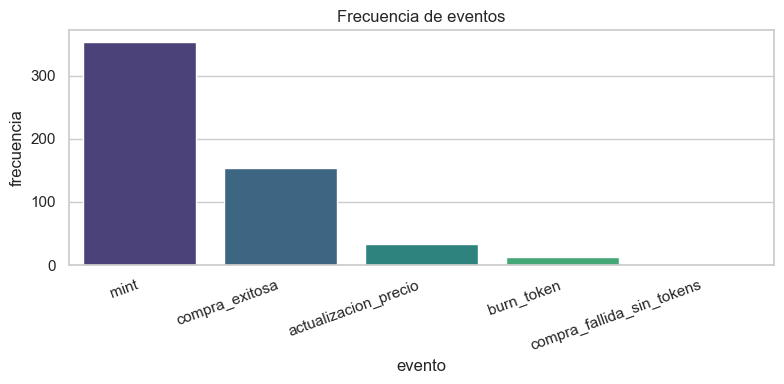

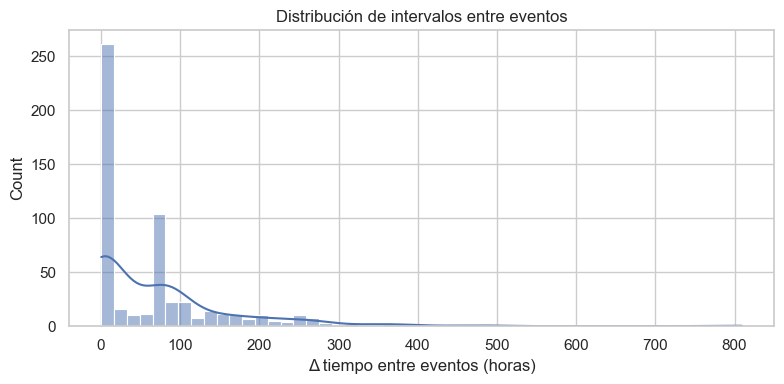

In [ ]:
import os, json
from pathlib import Path
import numpy as np
import pandas as pd

DO_PLOTS_SINGLE = True
HEAD_N          = 5
TIME_UNIT       = globals().get("TIME_UNIT", "horas")
BASE_OUT        = Path("outputs")

def _eda_sencilla(df_eventos: pd.DataFrame, time_unit="horas",
                  save_dir: Path | None = None, do_plots: bool = False,
                  head_n: int = 5):
    resumen = {
        "n_filas":    int(df_eventos.shape[0]),
        "n_cols":     int(df_eventos.shape[1]),
        "t_min":      float(df_eventos["tiempo"].min()) if "tiempo" in df_eventos.columns and len(df_eventos) else np.nan,
        "t_max":      float(df_eventos["tiempo"].max()) if "tiempo" in df_eventos.columns and len(df_eventos) else np.nan,
        "duracion":   np.nan,
        "mint":       int((df_eventos["evento"].str.lower()=="mint").sum()) if "evento" in df_eventos.columns else 0,
        "compra_ok":  int((df_eventos["evento"].str.lower()=="compra_exitosa").sum()) if "evento" in df_eventos.columns else 0,
        "compra_fail_fondos": int((df_eventos["evento"].str.lower()=="compra_fallida_fondos").sum()) if "evento" in df_eventos.columns else 0,
        "compra_fail_sintok": int((df_eventos["evento"].str.lower()=="compra_fallida_sin_tokens").sum()) if "evento" in df_eventos.columns else 0,
        "burn":       int((df_eventos["evento"].str.lower()=="burn_token").sum()) if "evento" in df_eventos.columns else 0,
    }
    if not np.isnan(resumen["t_min"]) and not np.isnan(resumen["t_max"]):
        resumen["duracion"] = float(resumen["t_max"] - resumen["t_min"])

    print("▶ Forma:", df_eventos.shape, " | cols:", list(df_eventos.columns))
    if "tiempo" in df_eventos.columns:
        print(f"▶ Tiempo: min={resumen['t_min']:.2f}, max={resumen['t_max']:.2f} {time_unit}, duración={resumen['duracion']:.2f} {time_unit}")
    print("▶ Top filas:")
    print(df_eventos.head(head_n).to_string(index=False))

    if do_plots:
        import matplotlib.pyplot as plt, seaborn as sns
        sns.set(style="whitegrid")

        evt_counts = df_eventos["evento"].value_counts()
        if len(evt_counts):
            df_evt = evt_counts.rename_axis('evento').reset_index(name='frecuencia')
            plt.figure(figsize=(8,4))
            sns.barplot(data=df_evt, x="evento", y="frecuencia", hue="evento",
                        palette="viridis", dodge=False, legend=False)
            plt.xticks(rotation=20, ha="right")
            plt.title("Frecuencia de eventos")
            plt.tight_layout()
            if save_dir:
                save_dir.mkdir(parents=True, exist_ok=True)
                plt.savefig(save_dir / "freq_eventos.png", dpi=150)
            plt.show()

        if "tiempo" in df_eventos.columns:
            intervalos = df_eventos["tiempo"].diff().dropna()
            if len(intervalos):
                plt.figure(figsize=(8,4))
                sns.histplot(intervalos, bins=50, kde=True)
                plt.xlabel(f"Δ tiempo entre eventos ({time_unit})")
                plt.title("Distribución de intervalos entre eventos")
                plt.tight_layout()
                if save_dir:
                    plt.savefig(save_dir / "intervalos_eventos.png", dpi=150)
                plt.show()

    return resumen

# Prioridad: usar eventos_all.csv si existe; sino, df_eventos del primer escenario
ev_all_path = BASE_OUT / "eventos_all.csv"
if ev_all_path.exists():
    df_all = pd.read_csv(ev_all_path)
    print(f"📦 EDA agregado: {len(df_all):,} filas — {df_all['scenario'].nunique()} escenarios")
    # Tomamos el primer escenario para una vista "tipo single"
    scen0 = df_all["scenario"].iloc[0]
    df_eventos = df_all[df_all["scenario"] == scen0].drop(columns=["scenario"]).reset_index(drop=True)
    _ = _eda_sencilla(df_eventos, time_unit=TIME_UNIT, save_dir=Path("outputs/eda"), do_plots=DO_PLOTS_SINGLE, head_n=HEAD_N)
else:
    assert 'df_eventos' in globals(), "df_eventos no está definido; corré el Driver primero."
    print("[EDA] Usando df_eventos en memoria (escenario único).")
    _ = _eda_sencilla(df_eventos, time_unit=TIME_UNIT, save_dir=Path("outputs/eda"), do_plots=DO_PLOTS_SINGLE, head_n=HEAD_N)

# 7. Variables de Resultados


=== RESULTADOS ===
CTS (Cantidad total de tokenizaciones solicitadas): 354
PTB (Porcentaje de tokens burneados): 3.39% (burn=12, emitidos=354)
PSC (Promedio de saldo compradores): 2104.70
CTF (Cantidad de transferencias fallidas): 1


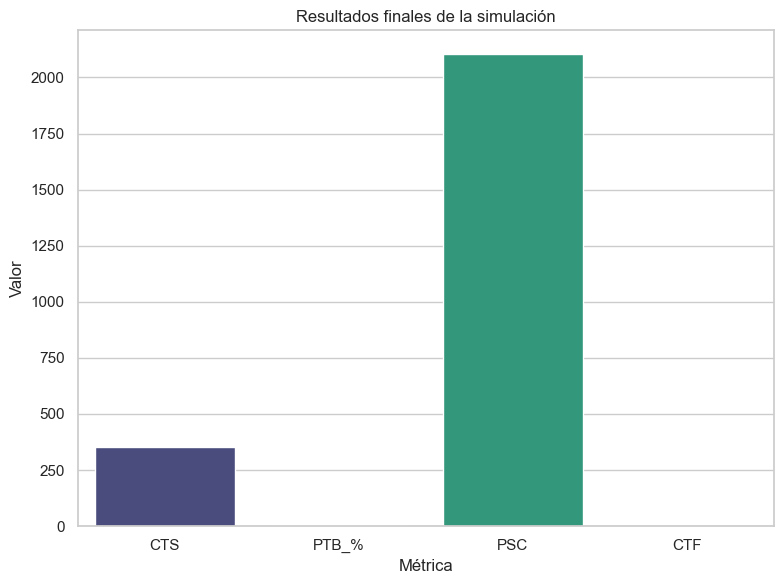

In [ ]:
import os, numpy as np, pandas as pd
os.makedirs("outputs", exist_ok=True)

# Helper: derivar métricas desde df_eventos si no hay globals
def _metrics_from_df(df):
    d = df.copy()
    d["evento"] = d["evento"].astype(str).str.lower()

    cts = int((d["evento"] == "mint").sum())
    ctf = int(d["evento"].isin(["compra_fallida_fondos", "compra_fallida_sin_tokens"]).sum())
    emitidos = cts
    burneados = int((d["evento"] == "burn_token").sum())

    # PSC: promedio del 'extra' en compras exitosas (saldo remanente del comprador)
    comp = pd.to_numeric(d.loc[d["evento"] == "compra_exitosa", "extra"], errors="coerce").dropna()
    psc = float(comp.mean()) if len(comp) > 0 else 0.0

    return cts, ctf, emitidos, burneados, psc

# Caso A: escenario único (las globals existen)
if all(k in globals() for k in ("CTS", "CTF", "tokens_emitidos", "tokens_burneados")):
    CTS_final = int(CTS)
    CTF_final = int(CTF)
    tokens_emitidos_final = int(tokens_emitidos)
    tokens_burneados_final = int(tokens_burneados)

    # PSC: si no hay saldos_compradores global, derivar de df_eventos
    if "saldos_compradores" in globals() and len(saldos_compradores) > 0:
        PSC_final = float(np.mean(saldos_compradores))
    else:
        _, _, _, _, PSC_final = _metrics_from_df(df_eventos)

# Caso B: batch/unificado (no hay globals): derivar TODO desde df_eventos
else:
    CTS_final, CTF_final, tokens_emitidos_final, tokens_burneados_final, PSC_final = _metrics_from_df(df_eventos)

PTB_final_pct = (tokens_burneados_final / tokens_emitidos_final * 100.0) if tokens_emitidos_final > 0 else 0.0

# Tabla de métricas y export
res_df = pd.DataFrame([
    {"metrica": "CTS",   "valor": CTS_final},
    {"metrica": "PTB_%", "valor": PTB_final_pct},
    {"metrica": "PSC",   "valor": PSC_final},
    {"metrica": "CTF",   "valor": CTF_final},
])
res_df.to_csv("outputs/metricas.csv", index=False)

# Exportar conteo de eventos
evt_counts = df_eventos["evento"].value_counts().rename_axis("evento").reset_index(name="frecuencia")
evt_counts.to_csv("outputs/conteo_eventos.csv", index=False)

# Prints formateados
print("\n=== RESULTADOS ===")
print(f"CTS (Cantidad total de tokenizaciones solicitadas): {CTS_final}")
print(f"PTB (Porcentaje de tokens burneados): {PTB_final_pct:.2f}% "
      f"(burn={tokens_burneados_final}, emitidos={tokens_emitidos_final})")
print(f"PSC (Promedio de saldo compradores): {PSC_final:.2f}")
print(f"CTF (Cantidad de transferencias fallidas): {CTF_final}")

# Gráfico (una sola vez)
import matplotlib.pyplot as plt, seaborn as sns
plt.figure(figsize=(8,6))
sns.barplot(
    data=res_df,
    x="metrica", y="valor",
    hue="metrica", palette="viridis",
    dodge=False, legend=False
)
plt.xlabel("Métrica"); plt.ylabel("Valor"); plt.title("Resultados finales de la simulación")
plt.tight_layout(); plt.savefig("outputs/metricas_bar.png", dpi=150); plt.show()

# 8. Visualizaciones de Resultados

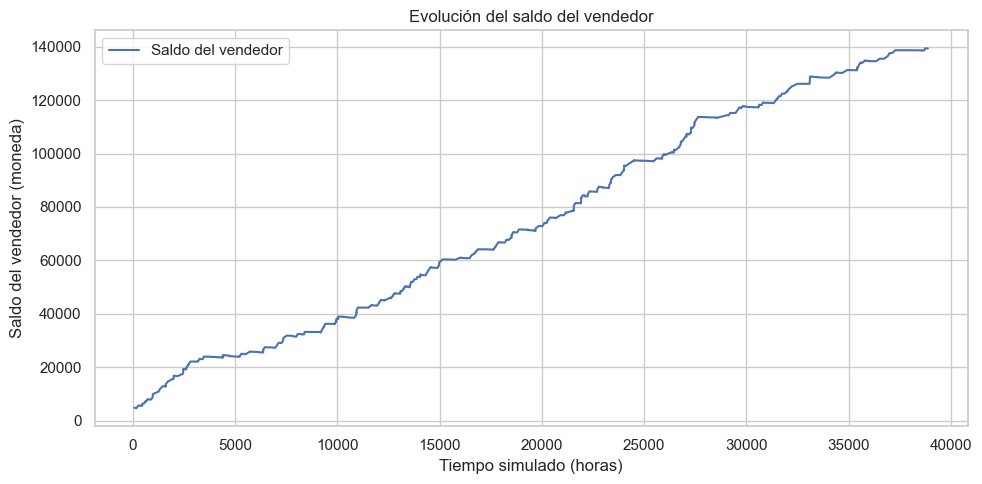

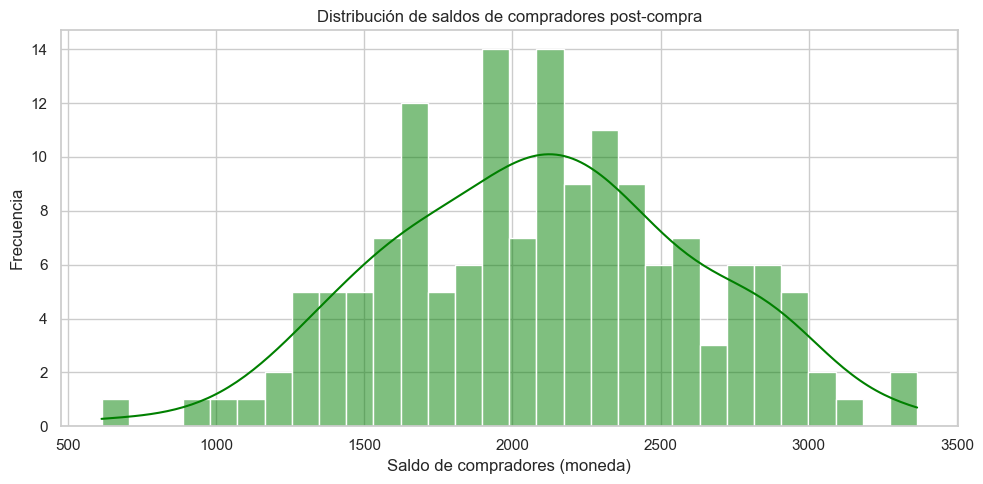

In [ ]:
import os
os.makedirs("outputs", exist_ok=True)

# Evolución del saldo del vendedor
plt.figure(figsize=(10,5))
sns.lineplot(data=df_eventos, x="tiempo", y="saldo_vendedor", label="Saldo del vendedor")
plt.xlabel(f"Tiempo simulado ({TIME_UNIT})")
plt.ylabel("Saldo del vendedor (moneda)")
plt.title("Evolución del saldo del vendedor")
plt.tight_layout()
plt.savefig("outputs/saldo_vendedor_tiempo.png", dpi=150)
plt.show()

# Distribución de saldos de compradores (solo si hubo compras)
if 'saldos_compradores' in globals() and len(saldos_compradores) > 0:
    plt.figure(figsize=(10,5))
    sns.histplot(saldos_compradores, bins=30, kde=True, color="green")
    plt.xlabel("Saldo de compradores (moneda)")
    plt.ylabel("Frecuencia")
    plt.title("Distribución de saldos de compradores post-compra")
    plt.tight_layout()
    plt.savefig("outputs/dist_saldos_compradores.png", dpi=150)
    plt.show()
else:
    print("No hay compras exitosas, no se grafica la distribución de saldos de compradores.")

# 9. Tokens en circulación vs tiempo

⏱ Tiempo simulado: 70.80 → 38877.40 horas
📏 Duración total: 38806.61 horas
📊 Registros: 554
🔢 Tokens en circulación (final): 342
📁 CSV: outputs/tokens_circulacion.csv
📁 Resumen guardado en: outputs/resumen_tiempo.csv


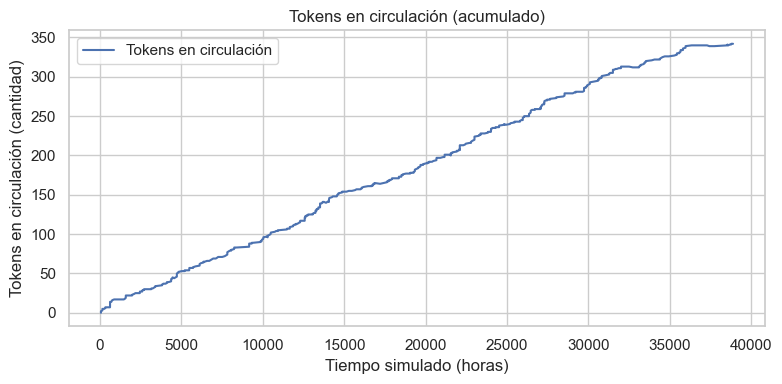

🖼️ PNG: outputs/tokens_circulacion.png


In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def generar_tokens_y_resumen(
    df_eventos: pd.DataFrame,
    csv_path: str = "outputs/tokens_circulacion.csv",
    png_path: str = "outputs/tokens_circulacion.png",
    resumen_path: str = "outputs/resumen_tiempo.csv",
    overwrite_csv: bool = True,
    make_plot: bool = True,
):
    os.makedirs(os.path.dirname(csv_path), exist_ok=True)

    # Validaciones mínimas
    if "evento" not in df_eventos.columns or "tiempo" not in df_eventos.columns:
        raise ValueError("df_eventos debe contener las columnas 'evento' y 'tiempo'.")

    # Normalización básica
    df = df_eventos.copy()
    df["evento"] = df["evento"].astype(str).str.lower()
    df["tiempo"] = pd.to_numeric(df["tiempo"], errors="coerce")

    # Solo 'mint' (+1) y 'burn_token' (-1) cambian el supply
    delta = df["evento"].map({"mint": 1, "burn_token": -1}).fillna(0).astype(int)

    tok = pd.DataFrame(
        {"tiempo": df["tiempo"], "tokens_circulacion": delta.cumsum()}
    ).dropna(subset=["tiempo"]).sort_values("tiempo", ignore_index=True)

    # Exportar CSV idempotente
    if overwrite_csv or not os.path.exists(csv_path):
        tok.to_csv(csv_path, index=False)

    # Resumen numérico
    if len(tok) > 0:
        t_min = float(tok["tiempo"].min())
        t_max = float(tok["tiempo"].max())
        duracion = t_max - t_min
        n_reg = int(len(tok))
        final_supply = int(tok["tokens_circulacion"].iloc[-1])
    else:
        t_min = t_max = duracion = 0.0
        n_reg = final_supply = 0

    print(f"⏱ Tiempo simulado: {t_min:.2f} → {t_max:.2f} {TIME_UNIT}")
    print(f"📏 Duración total: {duracion:.2f} {TIME_UNIT}")
    print(f"📊 Registros: {n_reg}")
    print(f"🔢 Tokens en circulación (final): {final_supply}")
    print(f"📁 CSV: {csv_path}")

    # Exportar resumen a CSV
    resumen_df = pd.DataFrame([{
        "tiempo_min": t_min,
        "tiempo_max": t_max,
        "duracion": duracion,
        "n_registros": n_reg,
        "tokens_final": final_supply,
        "unidad_tiempo": TIME_UNIT,
    }])
    resumen_df.to_csv(resumen_path, index=False)
    print(f"📁 Resumen guardado en: {resumen_path}")

    # Gráfico opcional
    if make_plot and len(tok) > 0:
        plt.figure(figsize=(8,4))
        plt.plot(tok["tiempo"], tok["tokens_circulacion"], label="Tokens en circulación")
        plt.xlabel(f"Tiempo simulado ({TIME_UNIT})")
        plt.ylabel("Tokens en circulación (cantidad)")
        plt.title("Tokens en circulación (acumulado)")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(png_path, dpi=150)
        plt.show()
        print(f"🖼️ PNG: {png_path}")

    return tok, resumen_df

tok, resumen_tiempo = generar_tokens_y_resumen(
    df_eventos,
    csv_path="outputs/tokens_circulacion.csv",
    png_path="outputs/tokens_circulacion.png",
    resumen_path="outputs/resumen_tiempo.csv",
    overwrite_csv=True,    # False para NO reescribir el CSV existente
    make_plot=True         # False para no generar el PNG
)

# 10. Conclusiones

In [ ]:
import os
import numpy as np
import pandas as pd
from textwrap import dedent

os.makedirs("outputs", exist_ok=True)

# ---- 1) Insumos: df_eventos, métricas, supply ----
# Métricas básicas (si no existen, las reconstruye)
CTS_val = int(CTS) if "CTS" in locals() else int((df_eventos["evento"].str.lower()=="mint").sum())
tokens_emitidos_val = int(tokens_emitidos) if "tokens_emitidos" in locals() else int((df_eventos["evento"].str.lower()=="mint").sum())
tokens_burneados_val = int(tokens_burneados) if "tokens_burneados" in locals() else int((df_eventos["evento"].str.lower()=="burn_token").sum())

if "PTB_final_pct" in locals():
    PTB_pct = float(PTB_final_pct)
else:
    PTB_pct = (tokens_burneados_val / tokens_emitidos_val * 100.0) if tokens_emitidos_val>0 else 0.0

PSC_val = float(PSC_final) if "PSC_final" in locals() else float(np.nan)
CTF_val = int(CTF) if "CTF" in locals() else int((df_eventos["evento"].str.contains("compra_fallida", case=False, na=False)).sum())

# Supply vs tiempo
tok_path = "outputs/tokens_circulacion.csv"
if os.path.exists(tok_path):
    tok = pd.read_csv(tok_path)
else:
    df = df_eventos.copy()
    df["evento"] = df["evento"].astype(str).str.lower()
    df["tiempo"] = pd.to_numeric(df["tiempo"], errors="coerce")
    delta = df["evento"].map({"mint": 1, "burn_token": -1}).fillna(0).astype(int)
    tok = pd.DataFrame({"tiempo": df["tiempo"], "tokens_circulacion": delta.cumsum()}).dropna(subset=["tiempo"]).sort_values("tiempo", ignore_index=True)

t_min = float(tok["tiempo"].min()) if len(tok)>0 else 0.0
t_max = float(tok["tiempo"].max()) if len(tok)>0 else 0.0
duracion = t_max - t_min
final_supply = int(tok["tokens_circulacion"].iloc[-1]) if len(tok)>0 else 0

# Tendencia del supply al final (slope en el último 30%)
if len(tok) >= 5:
    tail = tok.tail(max(5, int(len(tok)*0.3)))
    try:
        m, b = np.polyfit(tail["tiempo"], tail["tokens_circulacion"], 1)
    except Exception:
        m = 0.0
    if m > 0.02: tendencia_supply = "creciente"
    elif m < -0.02: tendencia_supply = "decreciente"
    else: tendencia_supply = "estable"
else:
    tendencia_supply = "indefinida"

# ---- 2) Tasas, fallas y stock ----
compras_mask = df_eventos["evento"].str.contains("compra", case=False, na=False)
total_compras = int(compras_mask.sum())
exitosas = int((df_eventos["evento"].str.lower()=="compra_exitosa").sum())
tasa_exito = (exitosas/total_compras*100.0) if total_compras>0 else np.nan

fall_fondos = int((df_eventos["evento"].str.lower()=="compra_fallida_fondos").sum())
fall_sintok = int((df_eventos["evento"].str.lower()=="compra_fallida_sin_tokens").sum())

# Stock sin vender al cierre: mint - burn - vendidas
mint_ids  = set(df_eventos.loc[df_eventos["evento"].str.lower()=="mint", "token"].dropna())
burn_ids  = set(df_eventos.loc[df_eventos["evento"].str.lower()=="burn_token", "token"].dropna())
sold_ids  = set(df_eventos.loc[df_eventos["evento"].str.lower()=="compra_exitosa", "token"].dropna())
stock_sin_vender = max(0, len(mint_ids - burn_ids - sold_ids))

# ---- 3) Intervalos TS / LLIN y mejor FDP si existiera ----
ts_series = tiempos_ts if 'tiempos_ts' in globals() else (
    df_eventos.loc[df_eventos["evento"].str.lower()=="mint", "tiempo"]
    .diff().dropna()
)
llin_series = tiempos_llin if 'tiempos_llin' in globals() else (
    df_eventos.loc[df_eventos["evento"].str.contains("compra", case=False, na=False), "tiempo"]
    .diff().dropna()
)

ts_mean   = float(ts_series.mean()) if len(ts_series)>0 else np.nan
llin_mean = float(llin_series.mean()) if len(llin_series)>0 else np.nan

def _best_name_from_dataset(best_dict):
    try:
        return list(best_dict.keys())[0] if best_dict else None
    except Exception:
        return None

# 1) Intentar con los fits del DATASET (bloque 2.1)
best_ts_name = _best_name_from_dataset(best_ts_dataset) if 'best_ts_dataset' in globals() else None
best_llin_name = _best_name_from_dataset(best_llin_dataset) if 'best_llin_dataset' in globals() else None

# 2) Si no están en memoria, leer de outputs/ajustes_fdp_dataset.csv
if (best_ts_name is None or best_llin_name is None) and os.path.exists("outputs/ajustes_fdp_dataset.csv"):
    try:
        aj = pd.read_csv("outputs/ajustes_fdp_dataset.csv")
        if best_ts_name is None:
            row = aj.loc[aj["variable"] == "TS"]
            if not row.empty: best_ts_name = str(row.iloc[0]["mejor_dist"])
        if best_llin_name is None:
            row = aj.loc[aj["variable"] == "LLIN"]
            if not row.empty: best_llin_name = str(row.iloc[0]["mejor_dist"])
    except Exception:
        pass

# Fallback final: leer archivos si existen
if best_ts_name is None or best_llin_name is None:
    for path in ["outputs/ajustes_fdp_sim.csv", "outputs/ajustes_fdp.csv"]:
        if os.path.exists(path):
            try:
                aj = pd.read_csv(path)
                if best_ts_name is None:
                    row = aj.loc[aj["variable"].str.contains("TS", na=False)]
                    if not row.empty: best_ts_name = str(row.iloc[0]["mejor_dist"])
                if best_llin_name is None:
                    row = aj.loc[aj["variable"].str.contains("LLIN", na=False)]
                    if not row.empty: best_llin_name = str(row.iloc[0]["mejor_dist"])
            except: 
                pass

# ---- 4) Recomendaciones automáticas (simples) ----
recs = []

# Oferta vs demanda
if not np.isnan(ts_mean) and not np.isnan(llin_mean):
    if ts_mean > llin_mean:
        recs.append("La tokenización (TS) es más lenta que las llegadas (LLIN): podés **acelerar TS** (mayor emisión) o **aumentar `partes_de_prop`** para reducir faltantes.")
    else:
        recs.append("La tokenización (TS) es más rápida que las llegadas (LLIN): el supply se repone bien; revisá **estrategias de precio** si hay fallas por fondos.")

# Motivo principal de fallas
if fall_sintok > fall_fondos:
    recs.append("Las fallas por **falta de tokens** dominan: aumentar frecuencia de `mint` o **reducir `burn`** puede ayudar.")
elif fall_fondos > fall_sintok:
    recs.append("Las fallas por **fondos insuficientes** dominan: considerá **bajar `VALOR_TOKEN_MEDIA`** o modificar la distribución de saldos de compradores.")
else:
    if total_compras>0:
        recs.append("Las fallas se reparten parejo entre fondos y disponibilidad; podés actuar en ambos frentes: oferta y pricing.")

# PTB alto
if PTB_pct >= 20:
    recs.append("**PTB** elevado: revisar criterios de `burn_token` (P_BURN) para no erosionar el supply.")
elif PTB_pct <= 1 and tendencia_supply=="creciente":
    recs.append("**PTB** muy bajo y supply creciente: OK si es deseado; de lo contrario, introducir `burn` para controlar el circulante.")

# ---- 5) Componer conclusiones (Markdown) ----
ts_line   = f"- Tokenización (TS): media ≈ {ts_mean:.2f} {TIME_UNIT}" if not np.isnan(ts_mean) else "- Tokenización (TS): sin datos suficientes"
ts_line  += f"{' — mejor FDP: '+best_ts_name if best_ts_name else ''}"

llin_line = f"- Llegadas (LLIN): media ≈ {llin_mean:.2f} {TIME_UNIT}" if not np.isnan(llin_mean) else "- Llegadas (LLIN): sin datos suficientes"
llin_line+= f"{' — mejor FDP: '+best_llin_name if best_llin_name else ''}"

tasa_line = f"- Compras: {exitosas}/{total_compras} exitosas (**{tasa_exito:.1f}%**)" if total_compras>0 else "- Compras: sin eventos registrados"

conclusiones_md = dedent(f"""
## Conclusiones

**Horizonte & Supply**
- Horizonte simulado: {duracion:.2f} {TIME_UNIT} (de {t_min:.2f} a {t_max:.2f}).
- Supply en circulación al cierre: **{final_supply}** tokens — tendencia **{tendencia_supply}**.
- PTB (burn): **{PTB_pct:.2f}%** ({tokens_burneados_val}/{tokens_emitidos_val}).
- Stock sin vender al cierre: **{stock_sin_vender}** tokens.

**Ritmos del sistema**
{ts_line}
{llin_line}

**Demanda & Éxito de compras**
{tasa_line}
- Fallidas por fondos: {fall_fondos}
- Fallidas por falta de tokens: {fall_sintok}

**Recomendaciones rápidas**
- """ + "\n- ".join(recs) + """
""").strip()

print(conclusiones_md)

with open("outputs/conclusiones.md", "w", encoding="utf-8") as f:
    f.write(conclusiones_md + "\n")

print("📁 Conclusiones guardadas en: outputs/conclusiones.md")

## Conclusiones

**Horizonte & Supply**
- Horizonte simulado: 38806.61 horas (de 70.80 a 38877.40).
- Supply en circulación al cierre: **342** tokens — tendencia **estable**.
- PTB (burn): **3.39%** (12/354).
- Stock sin vender al cierre: **189** tokens.

**Ritmos del sistema**
- Tokenización (TS): media ≈ 12.08 horas — mejor FDP: foldnorm
- Llegadas (LLIN): media ≈ 23.09 horas — mejor FDP: burr12

**Demanda & Éxito de compras**
- Compras: 153/154 exitosas (**99.4%**)
- Fallidas por fondos: 0
- Fallidas por falta de tokens: 1

**Recomendaciones rápidas**
- La tokenización (TS) es más rápida que las llegadas (LLIN): el supply se repone bien; revisá **estrategias de precio** si hay fallas por fondos.
- Las fallas por **falta de tokens** dominan: aumentar frecuencia de `mint` o **reducir `burn`** puede ayudar.
📁 Conclusiones guardadas en: outputs/conclusiones.md
